# 06. 일반화 달성

## 샘플 외 데이터 검사

### 샘플 분할 테스트

In [4]:
import pandas as pd
from sklearn.datasets import load_boston
boston = load_boston()
dataset = pd.DataFrame(boston.data, columns=boston.feature_names)
dataset['target'] = boston.target
observations = len(dataset)
variables = dataset.columns[:-1]
X = dataset.iloc[:,:-1]
y = dataset['target'].values

보스턴 주택 데이터를 불러오자.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.30, random_state=101)
print("Train dataset sample size: %i" % len(X_train))
print("Test dataset sample size : %i" % len(X_test))

Train dataset sample size: 354
Test dataset sample size : 152


훈련 부분과 테스트 부분을 나눈다.

In [6]:
X_train, X_out_sample, y_train, y_out_sample = train_test_split(X, y,
                                                   test_size=0.40, random_state=101)
X_validation, X_test, y_train, y_validation = train_test_split(X_out_sample, y_out_sample,
                                                   test_size=0.50, random_state=101)
print("Train dataset sample size: %i" % len(X_train))
print("Validation dataset sample size: %i" % len(X_validation))
print("Test dataset sample size : %i" % len(X_test))

Train dataset sample size: 303
Validation dataset sample size: 101
Test dataset sample size : 102


train_test_split을 두 단계로 사용해 모델에 따라 어떤 파라미터가 최적일 수 있는지 확인할 수 있다.

### 교차 검증

* 교차 검증은 훈련과 테스트를 위해 데이터를 분리하고 모든 관찰이 훈련과 테스트의 역할을 수행할 때까지 반복적으로 진행하는 것을 요구한다.
즉, 데이터를 분할할 상호 배타적인 부분의 수를 결정한 다음, 모든 폴드를 사용하지만 매번 다른 폴드를 사용해 모델을 반복적으로 훈련시킨다.

In [12]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

def RMSE(y_true, y_pred):
    return np.sum((y_true -y_pred)**2)
lm = LinearRegression()
cv_iterator = KFold(n_splits=10, shuffle=True, random_state=101)
edges = np.histogram(y, bins=5)[1]
binning = np.digitize(y, edges)
stratified_cv_iterator = StratifiedKFold(n_splits=10, shuffle=True, random_state=101)

second_order=PolynomialFeatures(degree=2, interaction_only=False)
third_order=PolynomialFeatures(degree=3, interaction_only=True)

over_param_X = second_order.fit_transform(X)
extra_over_param_X = third_order.fit_transform(X)
cv_score = cross_val_score(lm, over_param_X, y, cv=cv_iterator, scoring='neg_mean_squared_error', n_jobs=1)

KFold와 StratifiedKFold 모두 반복자이지만, KFold는 무작위 추출을 한다는 점이 다르다.

StratifiedKFold는 목표변수의 분포를 원래 집합에 있는 것 처럼 고려한다.

In [13]:
print(cv_score)

[-11.67358613 -22.84201585  -9.19318785 -19.77458934 -11.68472903
  -9.15302456 -12.97982141 -22.18260706 -35.93064657 -13.75241158]


In [14]:
print('Cv score : mean %0.3f std %0.3f' % (np.mean(np.abs(cv_score)), np.std(cv_score)))

Cv score : mean 16.917 std 7.955


In [15]:
cv_score = cross_val_score(lm, over_param_X, y, cv=stratified_cv_iterator.split(X,binning), 
                           scoring='neg_mean_squared_error', n_jobs=1)
print('Cv score : mean %0.3f std %0.3f' % (np.mean(np.abs(cv_score)), np.std(cv_score)))

Cv score : mean 15.645 std 6.517


목표변수를 계층화한 경우, 추정오차의 표전편차가 낮아진다.

### 부트스트래핑

In [16]:
import random 
def Bootstrap(n, n_iter=3, random_state=None) :
    if random_state :
        random.seed(random_state)
        for j in range(n_iter) :
            bs = [random.randint(0, n-1) for i in range(n)]
            out_bs = list({i for i in range(n)} - set(bs))
            yield bs, out_bs
            
boot = Bootstrap(n=10, n_iter=5, random_state=101)
for train_idx, validation_idx in boot:
    print(train_idx, validation_idx)

[9, 3, 8, 5, 7, 0, 8, 3, 9, 3] [1, 2, 4, 6]
[4, 7, 3, 5, 7, 1, 4, 3, 2, 1] [0, 8, 6, 9]
[7, 8, 5, 3, 7, 5, 3, 6, 6, 3] [0, 1, 2, 4, 9]
[1, 6, 7, 4, 3, 1, 9, 5, 4, 6] [0, 8, 2]
[6, 3, 6, 1, 6, 6, 0, 7, 3, 8] [9, 2, 4, 5]


In [17]:
import numpy as np
boot = Bootstrap(n=len(X), n_iter=10, random_state=101)
lm = LinearRegression()
bootstrapped_coef = np.zeros((10,13))
for k, (train_idx, validation_idx) in enumerate(boot) : 
    lm.fit(X.iloc[train_idx,:],y[train_idx])
    bootstrapped_coef[k,:] = lm.coef_

부트스트랩 복제에서 계수가 어떻게 결정되는 지 검사할 수 있으므로 각각의 계수가 얼마나 안정적인지 확인할 수 있다.

In [18]:
print(bootstrapped_coef[:,10])
print(bootstrapped_coef[:,6])

[-1.0403394  -0.93588809 -1.09205904 -1.10308266 -0.99606246 -0.79789273
 -0.89314749 -0.92206747 -1.02555442 -0.78963414]
[-0.01947474  0.00046413 -0.00026774  0.00604679  0.02211687 -0.00089469
  0.01919428  0.02155958  0.01222277 -0.027093  ]


10번째 계수는 부호와 값 모두 안정적이지만 6번째 계수는 변동이 크다.

## 특성의 그리디 선택

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.30, random_state=3)
lm=LinearRegression()
lm.fit(X_train, y_train)
print('Train (cases, features) = %s' %str(X_train.shape))
print('Test (cases, features) = %s' %str(X_test.shape))
print('In-Sample mean squared error %0.3f' 
      %mean_squared_error(y_train, lm.predict(X_train)))
print('Out-Sample mean squared error %0.3f' 
      %mean_squared_error(y_test, lm.predict(X_test)))

Train (cases, features) = (354, 13)
Test (cases, features) = (152, 13)
In-Sample mean squared error 22.420
Out-Sample mean squared error 22.432


현재 가지고 있는 사례와 특성을 찾고 기본 성능이 무엇인지 알아보자.

In [20]:
from sklearn.preprocessing import PolynomialFeatures
second_order = PolynomialFeatures(degree=2, interaction_only=False)
third_order = PolynomialFeatures(degree=3, interaction_only=True)

다항식 확장을 사용해 모델을 개선한다.

2차 다항식 확장

In [22]:
lm.fit(second_order.fit_transform(X_train),y_train)

print('(cases, features) = %s' %str(second_order.fit_transform(X_train).shape))
print('In-Sample mean squared error %0.3f' %
      mean_squared_error(y_train, lm.predict(second_order.fit_transform(X_train))))
print('Out-Sample mean squared error %0.3f' %
      mean_squared_error(y_test, lm.predict(second_order.fit_transform(X_test))))

(cases, features) = (354, 105)
In-Sample mean squared error 14.599
Out-Sample mean squared error 29.190


3차 다항식 확장

In [23]:
lm.fit(third_order.fit_transform(X_train), y_train)
print('(cases, features) = %s' %str(third_order.fit_transform(X_train).shape))
print('In-Sample mean squared error %0.3f' %
      mean_squared_error(y_train, lm.predict(third_order.fit_transform(X_train))))
print('Out-Sample mean squared error %0.3f' %
      mean_squared_error(y_test, lm.predict(third_order.fit_transform(X_test))))

(cases, features) = (354, 378)
In-Sample mean squared error 0.438
Out-Sample mean squared error 85777.227


### 마델론 데이터셋

In [37]:
try :
    import urllib.request as urllib2
except : 
    import urllib2
import numpy as np

train_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.data'
validation_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_valid.data'
train_response = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.labels'
validation_response = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/madelon_valid.labels'

try :
    Xt = np.loadtxt(urllib2.urlopen(train_data))
    yt = np.loadtxt(urllib2.urlopen(train_response))
    Xv = np.loadtxt(urllib2.urlopen(validation_data))
    yv = np.loadtxt(urllib2.urlopen(validation_response))
except : 
    Xt = np.loadtxt('madelon_train.data')
    yt = np.loadtxt('madelon_train.labels')
    Xv = np.loadtxt('madelon_valid.data')
    yv = np.loadtxt('madelon_valid.labels')

외부 사이트로부터 데이터셋을 다운로드하자.

In [25]:
print('Training set : %i observations %i feature' %(Xt.shape))
print('Validation set : %i observations %i feature' %(Xv.shape))

Training set : 2000 observations 500 feature
Validation set : 600 observations 500 feature


훈련 집합과 검증 집합 모두 로드한 후 사용 가능한 정보 중 일부를 탐색할 수 있다.

In [26]:
from scipy.stats import describe
print(describe(Xt))

DescribeResult(nobs=2000, minmax=(array([462., 381., 370., 453., 371., 459., 334., 471., 430., 455., 354.,
       389., 347., 352., 444., 410., 433., 377., 408., 441., 426., 412.,
       456., 438., 343., 416., 421., 441., 438., 417., 451., 382., 369.,
       363., 384., 342., 441., 396., 464., 471., 463., 362., 392., 438.,
       406., 392., 371., 373., 367., 382., 381., 382., 399., 465., 401.,
       409., 288., 377., 378., 408., 400., 462., 377., 458., 214., 385.,
       373., 395., 462., 452., 362., 427., 402., 354., 456., 371., 446.,
       396., 379., 424., 415., 385., 396., 430., 372., 391., 458., 406.,
       454., 377., 474., 395., 399., 438., 452., 384., 468., 406., 412.,
       355., 448., 448., 460., 428., 361.,   0., 349., 370., 391., 442.,
       392., 356., 450., 385., 353., 413., 418., 441., 389., 414., 469.,
       380., 437., 355., 406., 389., 440., 387., 435., 347., 401., 420.,
       402., 461., 403., 382., 369., 425., 461., 430., 427., 376., 443.,
       452., 421.

아웃풋은 매우 길고 행렬 형태로 주어지며 데이터셋에 있는 각 특성에 대해 평균, 최소, 최대, 분산, 왜도, 첨도에 관한 모든 것을 보여준다.

모든 변수가 거의 정규 분포를 가지고 있으며 값의 범위가 제한돼 있음을 알 수 있으며 변수들 사이의 상관관계를 그래프로 표시해 진행 할 수 있다.

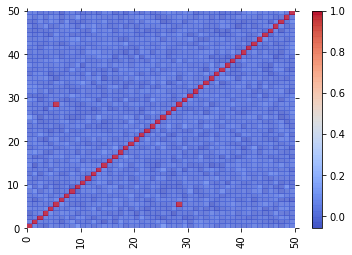

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def visualize_correlation_matrix(data, hurdle=0.0) : 
    R = np.corrcoef(data, rowvar=0)
    R[np.where(np.abs(R)<hurdle)] = 0.0
    heatmap = plt.pcolor(R, cmap=mpl.cm.coolwarm, alpha=0.8)
    heatmap.axes.set_frame_on(False)
    plt.xticks(rotation=90)
    plt.tick_params(axis='both', which='both', bottom='off',
                    top='off', left='off', right='off')
    plt.colorbar()
    plt.show()

visualize_correlation_matrix(Xt[:,100:150], hurdle=0.0)

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter=3000)
logit.fit(Xt,yt)

from sklearn.metrics import roc_auc_score
print('Training area under the curve : %0.3f'
      % roc_auc_score(yt, logit.predict_proba(Xt)[:,:1]))
print('Validation are under the curve : %0.3f'
      % roc_auc_score(yv, logit.predict_proba(Xv)[:,:1]))

Training area under the curve : 0.176
Validation are under the curve : 0.399


/Users/igyeongdon/opt/anaconda3/envs/lkd/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC 오류측정 

### 특성의 일변량 선택

In [31]:
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=50)
selector.fit(Xt,yt)
variable_filter = selector.get_support()

분류 문제를 작업하기 위해 f-class를 사용하고, 특정 비율의 높은 점수를 갖는 특성을 선택하기 위해 SelectPercentile 함수를 사용한다.

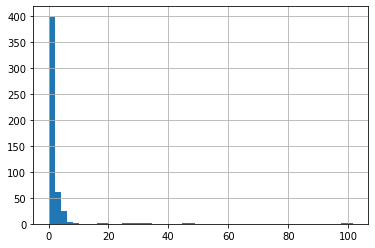

In [32]:
plt.hist(selector.scores_, bins=50, histtype='bar')
plt.grid()
plt.show()

가장 부적절한 특성을 제거하고 중요한 것들을 유지하기 위해 위쪽 절반을 선택한 후 결과를 히스토그램으로 플롯해 점수 분포를 나타냈다. 

In [39]:
variable_filter = selector.scores_ > 10
print('Number of filtered variables : %i' %np.sum(variable_filter))

from sklearn.preprocessing import PolynomialFeatures
interactions = PolynomialFeatures(degree=2, interaction_only=True)
Xs = interactions.fit_transform(Xt[:,variable_filter])
print("Number of variables and interactions ; %i" %Xs.shape[1])

Number of filtered variables : 13
Number of variables and interactions ; 92


경험적으로 선택한 임계값을 직접 선택해 중요한 것으로 추정되는 특성을 선택하여 축소했다. 

In [34]:
logit = LogisticRegression(max_iter=20000)
logit.fit(Xs,yt)
Xvs = interactions.fit_transform(Xv[:,variable_filter])
print('Validation area Under the Curve ' +
      'before recursive selection : %0.3f'
      %roc_auc_score(yv, logit.predict_proba(Xvs)[:,1]))

Validation area Under the Curve before recursive selection : 0.812


/Users/igyeongdon/opt/anaconda3/envs/lkd/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


다항식 확장을 테스트하고 모델에 관련된 모든 비선형 관계를 자동으로 포착한다. 결과 검정 점수는 약 0.81이다.

### 재귀적 특성 선택

* 재귀적 제거는 전체 모델로 시작해 각 변수를 차례로 제거함으로써 교차 검증에 의한 제거 효과를 평가한다.

In [43]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.30, random_state=1)

lm=LinearRegression()
cv_iterator = KFold(n_splits=10,
                    shuffle=True,
                    random_state=101)
recursive_selector = RFECV(estimator=lm, step=1, cv=cv_iterator,
                           scoring='neg_mean_squared_error')
recursive_selector.fit(second_order.fit_transform(X_train),y_train)

print('Initial number of features : %i' % 
      second_order.fit_transform(X_train).shape[1])
print('Optimal number of features : %i' % 
      recursive_selector.n_features_)

Initial number of features : 105
Optimal number of features : 53


2차 다항식 확장으로 향상된 보스턴 데이터셋을 이용하여 Scikit-learn의 RFECV가 재귀적 제거를 구현했다. 

In [44]:
essential_X_train = recursive_selector.transform(second_order.fit_transform(X_train))
essential_X_test = recursive_selector.transform(second_order.fit_transform(X_test))
lm.fit(essential_X_train,y_train)
print('cases = %i features = %i' %essential_X_test.shape)
print('In-Sample mean squared error %0.3f' 
      %mean_squared_error(y_train, lm.predict(essential_X_train)))
print('Out-Sample mean squared error %0.3f' 
      %mean_squared_error(y_test, lm.predict(essential_X_test)))

cases = 152 features = 53
In-Sample mean squared error 7.845
Out-Sample mean squared error 11.852


에스티메이터, 교차 검증 반복자 및 오류 측정을 감안해 RFECV는 성능이 저하될 우려 없이 특성의 절반을 모델에서 삭제할 수 있음을 확인할 수 있다.

In [45]:
edges = np.histogram(y, bins=5)[1]
binning = np.digitize(y,edges)
stratified_cv_iterator = StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=101)
essential_X = recursive_selector.transform(second_order.fit_transform(X))
cv_score = cross_val_score(lm, essential_X, y,
                          cv=stratified_cv_iterator.split(X,binning),
                          scoring = 'neg_mean_squared_error', n_jobs=1)
print('Cv score : mean %0.3f std %0.3f'
      % (np.mean(np.abs(cv_score)), np.std(cv_score)))

Cv score : mean 10.857 std 4.852


교차 검증을 통해서 유사한 결과를 얻는다는 것을 확인할 수 있다.

## 그리드 검색에 의한 최적화된 정규화

## 리지(L2 정규화)


In [47]:
from sklearn.linear_model import Ridge
ridge = Ridge(normalize=True)
ridge.fit(second_order.fit_transform(X),y)
lm.fit(second_order.fit_transform(X),y)

LinearRegression()

정규화가 모델에 미치는 영향은 Ridge의 alpha 파라미터와 LogisticRegression의 C 파라미터에 의해 제어된다.

alpha 값이 작을수록 계수값이 정규화에 의해 제어되는 양이 적어지며, 정규화가 증가해 값이 커질수록 계수는 더 많이 줄어든다.

LogisticRegression의 C 파라미터는 반대로 높은 정규화에 해당하는 값이 더 작다.

In [49]:

print('Average coefficient : Non regularized = %0.3f Ridge = %0.3f'
      % (np.mean(lm.coef_), np.mean(ridge.coef_)))
print('Min coefficient : Non regularized = %0.3f Ridge = %0.3f'
      % (np.min(lm.coef_), np.min(ridge.coef_)))
print('Max coefficient : Non regularized = %0.3f Ridge = %0.3f'
      % (np.max(lm.coef_), np.max(ridge.coef_)))


Average coefficient : Non regularized = 7592022.977 Ridge = -0.027
Min coefficient : Non regularized = -35.002 Ridge = -2.011
Max coefficient : Non regularized = 797162270.345 Ridge = 1.181


평균 계수값은 거의 0에 가까워지고 값은 이전보다 훨씬 작은 범위에 배치된다.

## 최적의 파라미터를 위한 그리드 검색

Scikit-learn 패키지의 GridSearchCV 클래스는 모델에서 변경해야 하는 파라미터와 평가할 값의 범위를 설명하는 사전을 설정한 후, 선호하는 cv 반복자와 점수를 사용해 설정할 수 있다. 마지막으로 이를 클래스의 param_grid 파라미터에 할당한다.

In [50]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(param_grid={'alpha' : np.logspace(-4,2,7)},
                      estimator=ridge, scoring='neg_mean_squared_error',
                      n_jobs=1, refit=True,
                      cv=stratified_cv_iterator.split(X,binning))
search.fit(second_order.fit_transform(X),y)
print('Best alpha : %0.5f' %search.best_params_['alpha'])
print('Best CV mean squared error : %0.3f' %np.abs(search.best_score_))

Best alpha : 0.00100
Best CV mean squared error : 12.121


In [54]:
for mean,std,par in zip(search.cv_results_['mean_test_score'],
                         search.cv_results_['std_test_score'],
                         search.cv_results_['params']) : 
    print("mean : {}, std : {}, params : {}".format(mean,std,par))

mean : -12.622903693160726, std : 4.370298562303391, params : {'alpha': 0.0001}
mean : -12.120562800260469, std : 5.563135389918355, params : {'alpha': 0.001}
mean : -12.285312261504613, std : 6.700871858830226, params : {'alpha': 0.01}
mean : -16.142626231988856, std : 7.895827677862889, params : {'alpha': 0.1}
mean : -22.733719238313448, std : 7.726761130585495, params : {'alpha': 1.0}
mean : -37.88917137493401, std : 7.704829355071151, params : {'alpha': 10.0}
mean : -66.6720083752863, std : 7.076009998693852, params : {'alpha': 100.0}


테스트해야 할 모델 변형이 많을 경우, 시간이 걸릴 수 있는 검색결과는 cv_results_ 속성을 사용해 탐색가능하다.

### 무작위 그리드 검색

* 무작위 검색은 사용자가 지적한 범이 또는 분포에서 가능한 파라미터를 샘플링해 작동한다.

In [55]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon
np.random.seed(101)
search_func=RandomizedSearchCV(estimator=ridge,
                              n_jobs=1, iid=False, refit=True, n_iter=10,
                              param_distributions={'alpha':np.logspace(-4,2,100)},
                              scoring='neg_mean_squared_error',
                              cv=stratified_cv_iterator.split(X,binning))
search_func.fit(second_order.fit_transform(X),y)
print('Best alpha : %0.5f' %search_func.best_params_['alpha'])
print('Best CV mean squared error : %0.3f' %np.abs(search_func.best_score_))

Best alpha : 0.00187
Best CV mean squared error : 12.101


/Users/igyeongdon/opt/anaconda3/envs/lkd/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


100개의 가능한 값에서 샘플링된 10개의 값만 사용하여 검색했다.

## 라쏘(L1 정규화)

* 라쏘 정규화는 정규화 패널티에서 2차값 대신 절대값을 사용해 많은 계수값을 0으로 줄여 결과 계수의 벡터를 희소하게 만든다.

In [56]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0, normalize=True, max_iter=10**5)

절차는 리지 회귀와 동일하지만, Lasso라고 하는 클래스를 사용한다. 하지만 분류 문제의 경우 로지스틱회귀에서 파라미터 penelty를 '11'로 지정해야 한다.

In [60]:

from scipy.stats import expon
np.random.seed(101)
search_func=RandomizedSearchCV(
    estimator=lasso, n_jobs=1, iid=False, refit=True, n_iter=15,
    param_distributions={'alpha':np.logspace(-5,2,100)},
    scoring='neg_mean_squared_error',
    cv=stratified_cv_iterator.split(X,binning))

search_func.fit(second_order.fit_transform(X),y)
print('Best alpha : %0.5f' %search_func.best_params_['alpha'])
print('Best CV mean squared error : %0.3f' %np.abs(search_func.best_score_))

/Users/igyeongdon/opt/anaconda3/envs/lkd/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.22613876687683, tolerance: 3.8524428263736263
  model = cd_fast.enet_coordinate_descent(
/Users/igyeongdon/opt/anaconda3/envs/lkd/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.04517536926096, tolerance: 3.807321151648352
  model = cd_fast.enet_coordinate_descent(
/Users/igyeongdon/opt/anaconda3/envs/lkd/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.86558246417644, tolerance: 3.8859739912087914
  model = cd_fast.enet_coordinate_descent(
/Users/igyeongdon/opt/anacond

Best alpha : 0.00014
Best CV mean squared error : 12.397


Lasso를 사용해 보스턴 데이터셋에서 이전의 선형회귀의 정규화가 어떻게 되는지 확인할 수 있다. 성능은 약간 더 나쁘지만 비교 가능한 정도의 평균 제곱오차의 값을 얻었다.

### 엘라스틱넷

* 엘라스틱넷에는 모델의 계수 결정에 대해 정규화의 영향을 조절하는 alpha 파라미터와 비용 함수의 정구화 부분의 L1 및 L2 사이의 결합에 대해 가중치를 부여하는 l1_ratio 파라미터가 존재한다. 파라미터가 0.0인 경우 L1에 대한 역할이 없음으로 리지와 같다. 파라미터가 1.0으로 설정되는 경우 라쏘 회귀를 실행한다. 중간값은 두가지 형식의 정규화 효과를 혼합해 작동한다.

In [63]:
from sklearn.linear_model import ElasticNet
elasticnet = ElasticNet(alpha=1.0, l1_ratio=0.15, normalize=True,
                        max_iter=10**6, random_state=101)

np.random.seed(101)
search_func=RandomizedSearchCV(estimator=elasticnet,
                              n_jobs=-1, iid=False, refit=True, n_iter=15,
                              param_distributions={'alpha':np.logspace(-5,2,100),
                                          'l1_ratio' : np.arange(0.0,1.01,0.05)},
                              scoring='neg_mean_squared_error',
                              cv=stratified_cv_iterator.split(X,binning))
search_func.fit(second_order.fit_transform(X),y)
print('Best alpha : %0.5f' %search_func.best_params_['alpha'])
print('Best CV mean squared error : %0.3f' %np.abs(search_func.best_score_))

/Users/igyeongdon/opt/anaconda3/envs/lkd/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Best alpha : 0.00002
Best CV mean squared error : 12.117


엘라스틱넷 정규화를 사용해 모델을 해결

In [64]:
print('Zero value coefficient : %i out of %i'
      % (np.sum(~(search_func.best_estimator_.coef_==0.0)),
        len(search_func.best_estimator_.coef_)))

Zero value coefficient : 102 out of 105


결과적으로 솔루션을 검토했을 때, 순수한 L1 솔루션보다 더 많은 수의 변수를 제외해 달성했다는 것을 알 수 있다. 

그러나 결과 성능은 L2 솔루션과 유사하다.